In [1]:
from autolens.imaging import image as im
from autolens.imaging import mask as ma
from autolens.profiles import mass_profiles as mp
from autolens.profiles import light_profiles as lp
from autolens.galaxy import galaxy as g
from autolens.lensing import ray_tracing
from autolens.lensing import lensing_image as li
from autolens.lensing import lensing_fitting
from autolens.inversion import pixelizations as pix
from autolens.inversion import regularization as reg
from autolens.plotting import lensing_fitting_plotters
from autolens.plotting import inversion_plotters

# I think you'll agree, inversions are a very powerful tool for modeling strong lenses. Now that our source galaxies
# comprise just a few parameters, we've got a much less complex non-linear parameter space to deal with. This allows us
# to fit more complex mass models, and thus ask ever more interesting scientific questions!

# However, inversions arn't perfect, especially when we use to them model lenses. These arn't huge issues, and they're
# easy to deal with, but its worth me explaining them now, so they don't trip you up when you start using inversions!

# So, what happens if we fit an image using an inversion and the wrong lens model? lets simulate an image and find out.

In [3]:
# The usual simulate function.
def simulate():

    from autolens.imaging import mask
    from autolens.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                        einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=90.0, intensity=0.2,
                                                         effective_radius=0.3, sersic_index=1.0))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    return im.Image.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

In [4]:
# And the same fitting function as the last tutorial
def perform_fit_with_lens_and_source_galaxy(lens_galaxy, source_galaxy):

    image = simulate()
    mask = ma.Mask.annular(shape=image.shape, pixel_scale=image.pixel_scale, inner_radius_arcsec=0.5,
                           outer_radius_arcsec=2.2)
    lensing_image = li.LensingImage(image=image, mask=mask)
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[lensing_image.grids], borders=[lensing_image.borders])
    return lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)

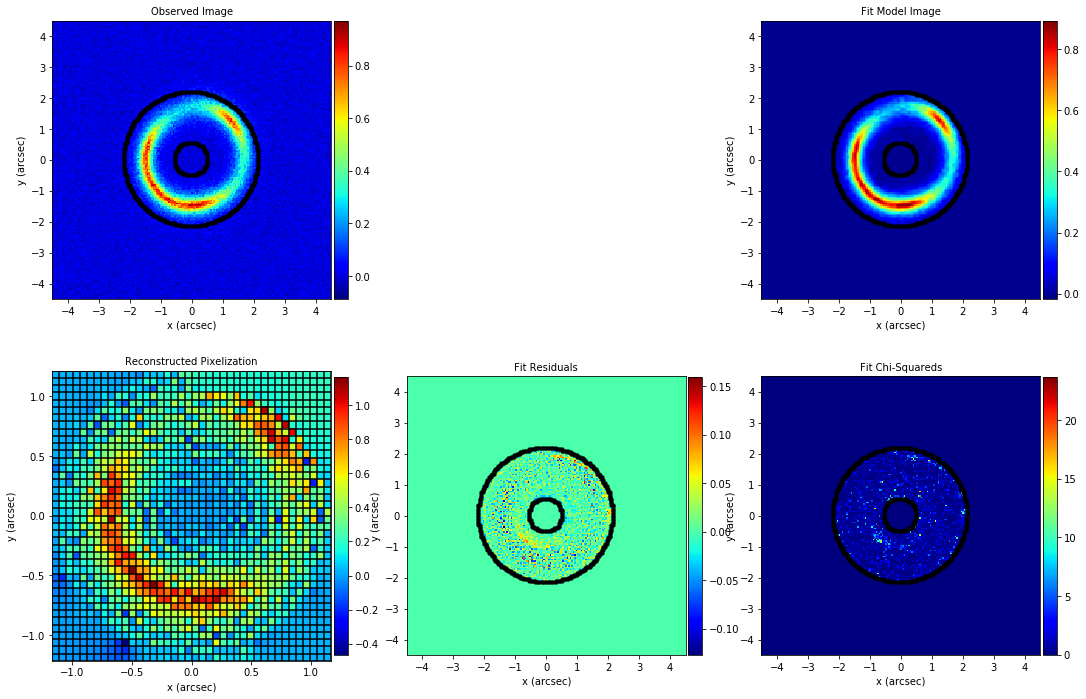

In [5]:
# This lens galaxy has the wrong mass-model -  I've reduced its Einstein Radius from 1.6 to 0.8.
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0, einstein_radius=0.8))
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(1.0,)))
fit = perform_fit_with_lens_and_source_galaxy(lens_galaxy=lens_galaxy, source_galaxy=source_galaxy)
lensing_fitting_plotters.plot_fitting_subplot(fit=fit)


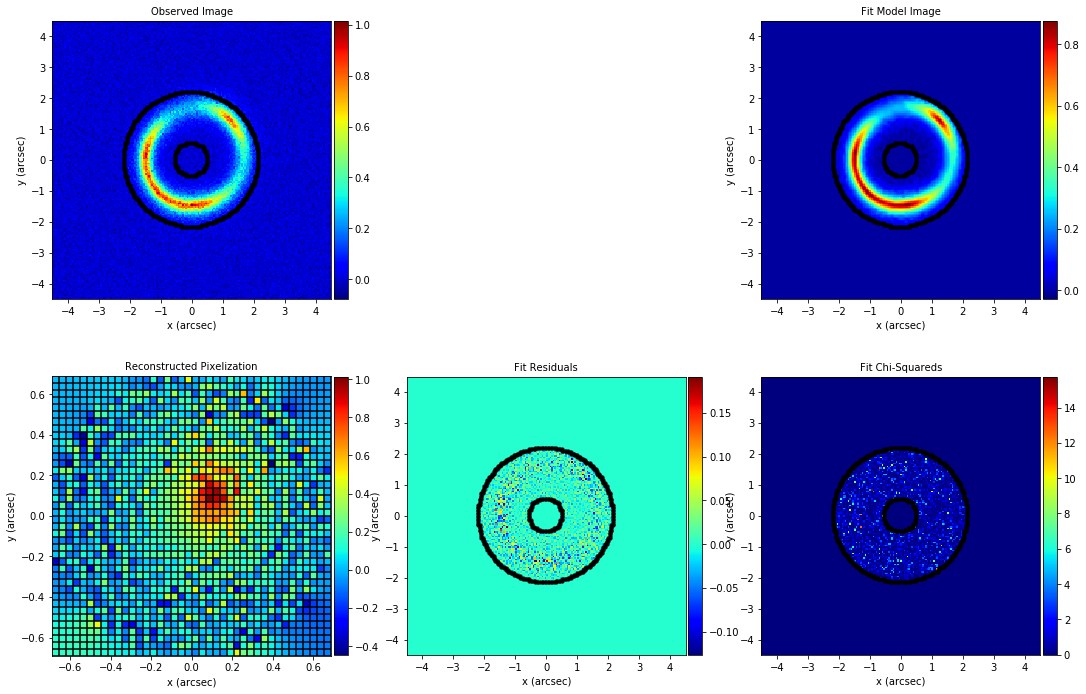

Bayesian Evidence of Incorrect Fit:
9462.26030636072
Bayesian Evidence of Correct Fit:


10320.8069809419


In [6]:
# What happened!? This incorrect mass-model provides a really good_fit to the image! The residuals and chi-squared map
# are as good as the ones we saw in the last tutorial.
#
# How can an incorrect lens model provide such a fit? Well, as I'm sure you noticed, the source has been reconstructed
# as a demagnified version of the image. Clearly, this isn't a physical solution or a solution that we want our
# non-linear search to find, but for inversions these solutions nevertheless exist.

# This isn't necessarily problematic for lens modeling. Afterall, the source reconstruction above is extremely complex,
# in that it requires a lot of pixels to fit the image accurately. Indeed, its Bayesian evidence is much lower than the
# correct solution.
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                    einstein_radius=1.6))
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(1.0,)))
correct_fit = perform_fit_with_lens_and_source_galaxy(lens_galaxy=lens_galaxy, source_galaxy=source_galaxy)
lensing_fitting_plotters.plot_fitting_subplot(fit=correct_fit)
print('Bayesian Evidence of Incorrect Fit:')
print(fit.evidence)
print('Bayesian Evidence of Correct Fit:')
print(correct_fit.evidence)

In [7]:
# Indeed, its evidence *is* lower. However, the difference in evidence isn't *that large*. This is going to
# be a problem for our non-linear search, as its suddenly going to see *a lot* of solutions with really high
# evidences. Furthermore, these solutions occupy the *vast majority* of parameter space (e.g. every single lens model
# that is wrong). This makes it easy for the non-linear search to get lost searching through these unphysical solutions
# and, unfortunately, infer an incorrect lens model (or, in non-linear speak, a local maxima).

# There is no simple fix for this. The reality is, when we use an inversion, these solutions exist. This is infact why
# pipelines were initially conceived - as they offer a simple solution to this problem. We can simply build a pipeline
# that begins by modeling the source galaxy as a light profile, 'initializing' our lens mass model. Then, when we
# switch to an inversion in the next phase, our mass model starts in the correct regions of parameter space and doesn't
# doesn't get lost sampling these incorrect solutions.
#
# Its not ideal - but with pipelines, its also not a big problem. Furthermore, light-profiles run faster computationally
# than inversions, so we'd probably want to do this anyway!


In [8]:
# Okay, so we've covered incorrect solutions, lets end by noting that we can model profiles and inversions at the same
# time. We do this when we want to simultaneously fit and subtract the light of a lens galaxy and reconstruct its lensed
# source using an inversion. To do this, all we have to do is give the lens galaxy a light profile.

def simulate_lens_with_light_profile():

    from autolens.imaging import mask
    from autolens.galaxy import galaxy as g
    from autolens.lensing import ray_tracing

    psf = im.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.05, pixel_scale=0.05)

    image_plane_grids = mask.ImagingGrids.grids_for_simulation(shape=(180, 180), pixel_scale=0.05, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(light=lp.SphericalSersic(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.8,
                                                    sersic_index=4.0),
                           mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                        einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=90.0, intensity=0.2,
                                                         effective_radius=0.3, sersic_index=1.0))

    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grids=[image_plane_grids])

    return im.PreparatoryImage.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.05,
                                        exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)


In [9]:
# When fitting such an image, we now want to include the lens's light in the analysis. thus, we should update our
# mask to be circular, and include the central regions of the image.
image = simulate_lens_with_light_profile()
mask = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=2.5)

In [10]:
# As I said above, performing this fit is the same as usual, we just give the lens galaxy a light profile:
lens_galaxy = g.Galaxy(light=lp.SphericalSersic(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.8,
                                                    sersic_index=4.0),
                       mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                    einstein_radius=1.6))

In [11]:
# These are just all the other things we do when setting up a fit.
source_galaxy = g.Galaxy(pixelization=pix.Rectangular(shape=(40, 40)), regularization=reg.Constant(coefficients=(1.0,)))

lensing_image = li.LensingImage(image=image, mask=mask)
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=[lensing_image.grids], borders=[lensing_image.borders])

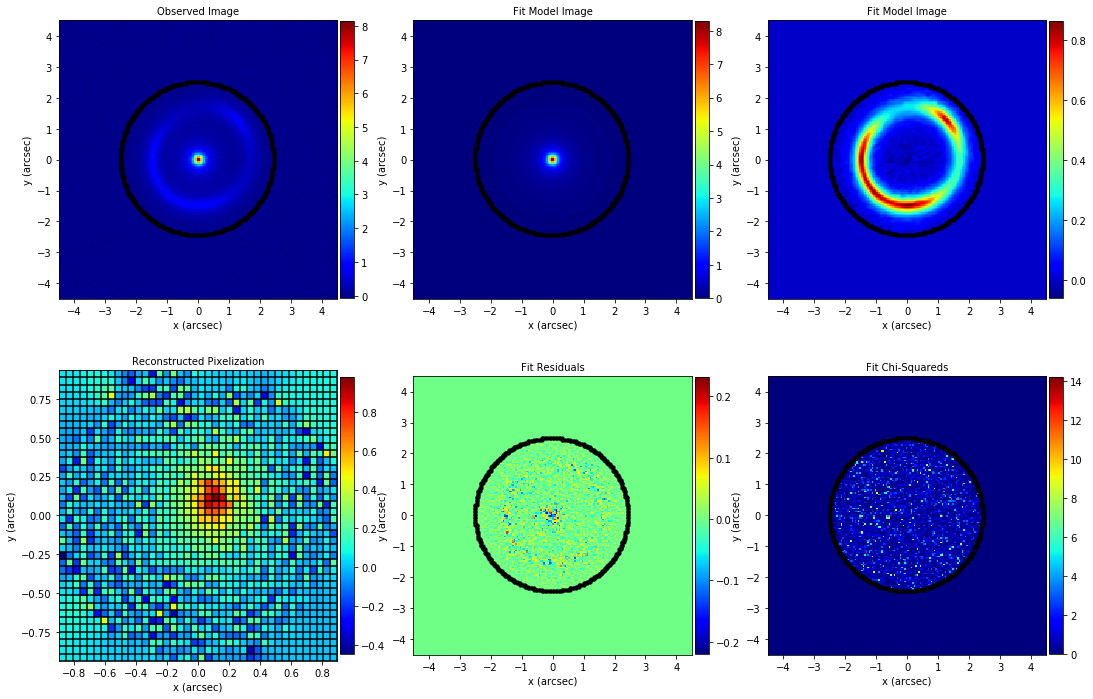

In [12]:
# This fit subtracts the lens galaxy's light from the image and fits the resulting source-only image with the inversion.
# When we plot the image, a new panel on the sub-plot appears showing the model image of the lens galaxy.
fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
lensing_fitting_plotters.plot_fitting_subplot(fit=fit)

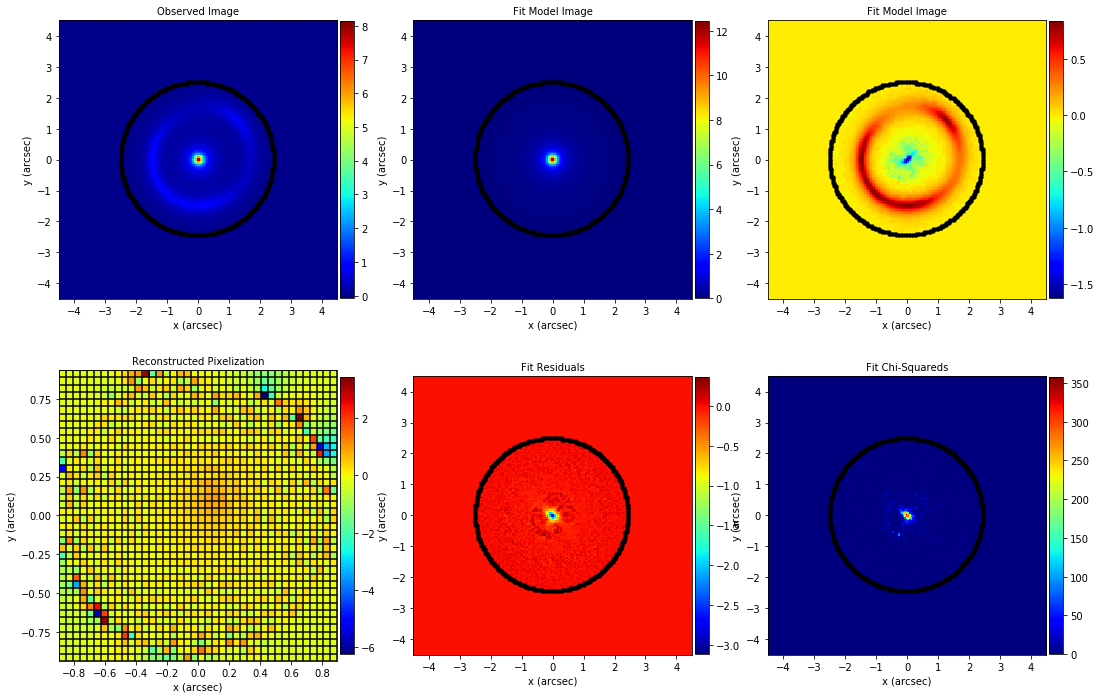

In [13]:
# Of course if the lens subtraction is rubbish, so is our fit, so we can be sure that our lens model wants to fit the
# lens galaxy's light accurately!
lens_galaxy = g.Galaxy(light=lp.SphericalSersic(centre=(0.0, 0.0), intensity=0.3, effective_radius=0.8,
                                                    sersic_index=4.0),
                       mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=135.0,
                                                    einstein_radius=1.6))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=[lensing_image.grids], borders=[lensing_image.borders])
fit = lensing_fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
lensing_fitting_plotters.plot_fitting_subplot(fit=fit)

In [13]:
# And with that, we're done. We've pretty much covered everything inversion related, so in the last tutorial I'll set
# you up with a pipeline that you can use to model lenses with an inversion.

# But first, I just want to point out a few things about what we've covered - to get you thinking about the next
# chapter, adaption.

# - The unphysical solutions above are clearly problematic. Whilst they have lower Bayesian evidences, their exsistance 
#   will still impact our inferences on the error-bars of our lens model. However, the pixelization's that we used in
#   this chapter are not adapted to the images they are fitting, and this means that the correct solutions achieve
#   much lower Bayesian evidence values than is actually possible. Thus, once we've covered adaption, these issues will
#   have completely been resolved!

# - When the lens galaxy's light is subtracted perfectly, it leaves no residuals. However, if it isn't subtracted 
#   perfectly, it does leave residuals, and these residuals will be fitted by the inversion. If the residual are
#   significant, this is going to really mess-up our source reconstruction and can lead to some pretty nasty 
#   systematics. In the next chapter, we'll learn how our adaptive analysis can prevent this residual fitting.